In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
# from voltron.robinhood_utils import GetStockData
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle

sns.set_style("whitegrid")
sns.set_palette("bright")

sns.set(font_scale=2.0)
sns.set_style('whitegrid')

import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.models import SingleTaskVariationalGP as SingleTaskCopulaProcessModel
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP
from voltron.means import LogLinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

In [2]:
# with open("../../stock_data.pkl", "rb") as handle:
#     raw_data = pickle.load(handle)
    
with open("./stock_data.pkl", "rb") as handle:
    raw_data = pickle.load(handle)

In [3]:
np.unique(raw_data["symbol"])

array(['AAPL', 'F', 'JPM', 'SBUX', 'TSLA', 'VIRT'], dtype=object)

In [18]:
raw_data

,date,symbol,open_price,close_price,high_price,low_price
0,2016-09-21,TSLA,41.2740,41.044,41.40000,40.31200
1,2016-09-22,TSLA,41.2800,41.286,41.45600,40.60000
2,2016-09-23,TSLA,41.1980,41.490,42.03600,41.13400
3,2016-09-26,TSLA,41.3000,41.798,42.20000,41.30000
4,2016-09-27,TSLA,41.9020,41.162,41.99636,40.92186
...,...,...,...,...,...,...
7549,2021-09-14,VIRT,23.7066,24.100,24.26500,23.48000
7550,2021-09-15,VIRT,24.1600,24.170,24.69000,24.12500
7551,2021-09-16,VIRT,24.4700,24.330,24.60000,24.23000
7552,2021-09-17,VIRT,24.2700,24.250,24.39000,24.01000


# Header

In [4]:
ntest = 200
ntrain = 200
tckrs = ['TSLA', "F", "JPM", "SBUX", 'AAPL', "VIRT"]
tckr = "VIRT"
span = "5year"
interval = 'day'
T = 5.

## Data Setup

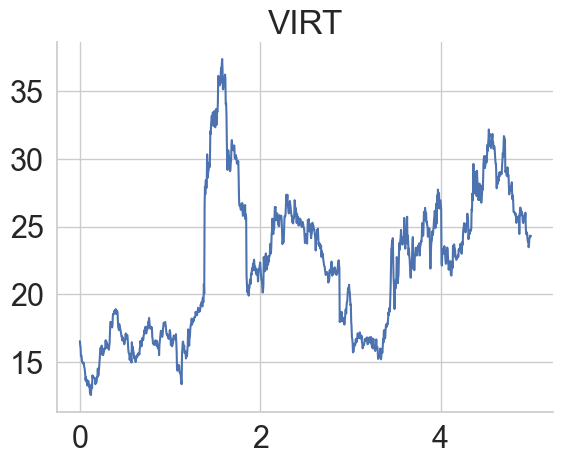

In [5]:
idx = -2
# data = GetStockData(tckr, span=span, interval=interval)
data = raw_data[raw_data["symbol"] == tckr]

ts = torch.linspace(0, T, data.shape[0])
# train_x = ts[:ntrain]
# test_x = ts[ntrain:(ntrain+ntest)]

y = torch.FloatTensor(data['close_price'].to_numpy())
log_returns = torch.log(y[1:]) - torch.log(y[:-1])
# train_y = y[:ntrain]
# test_y = y[ntrain:(ntrain+ntest)]

dt = ts[1] - ts[0]

plt.plot(ts, y)
plt.title(tckr);
sns.despine()
plt.show()

In [6]:
ts.shape

torch.Size([1259])

## Now apply GCPV

In [7]:
def get_and_fit_gpcv(x, log_returns):
    train_x = x[:-1]
    # prepare model
    likelihood = VolatilityGaussianLikelihood(param="exp")
    # likelihood.raw_a.data -= 6.
    covar_module = BMKernel()
    model = SingleTaskCopulaProcessModel(
        init_points=train_x.view(-1,1), 
        likelihood=likelihood, 
        use_piv_chol_init=False,
        mean_module = gpytorch.means.ConstantMean(), 
        covar_module=covar_module, 
        learn_inducing_locations=False
    )
    model.mean_module.constant.data -= 4.
    # model.initialize_variational_parameters(likelihood, train_x, y=log_returns)
    
    import os
    smoke_test = ('CI' in os.environ)
    training_iterations = 2 if smoke_test else 500


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    # likelihood parameters should be taken acct of in the model
    optimizer = torch.optim.Adam([
        {"params": model.parameters()}, 
        # {"params": likelihood.parameters(), "lr": 0.1}
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    # num_data refers to the number of training datapoints
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, log_returns.numel())
    
    old_loss = 10000.
    print_every = 50
    for i in range(training_iterations):
        # Zero backpropped gradients from previous iteration
        optimizer.zero_grad()
        # Get predictive output
        with gpytorch.settings.num_gauss_hermite_locs(75):
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, log_returns)
            loss.backward()
            if i % print_every == 0:
                print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
            optimizer.step()
        if old_loss <= loss and i > 100:
            print(old_loss, loss)
            break
        else:
            old_loss = loss.item()
            
    model.eval();
    likelihood.eval();
    predictive = model(x)
    pred_scale = likelihood(predictive).scale.mean(0).detach()
    samples = likelihood(predictive).scale.detach()
    
    plt.plot(x, pred_scale, linewidth = 4)
    plt.plot(x, samples.t(), color = "gray", alpha = 0.3)
    # plt.ylim((0, 0.25))
    plt.show()
    
    # return scaled volatility prediction
    return pred_scale / dt**0.5
    

In [8]:
def get_and_fit_vol_model(train_x, est_vol):
    vol_lh = gpytorch.likelihoods.GaussianLikelihood()
    vol_lh.noise.data = torch.tensor([1e-6])
    vol_model = BMGP(train_x, est_vol.log(), vol_lh)

    optimizer = torch.optim.Adam([
        {'params': vol_model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(vol_lh, vol_model)
    old_loss = 10000
    for i in range(500):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = vol_model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, est_vol.log())
        loss.backward()
        if i % 50 == 0:
            print(loss.item())
        optimizer.step()
#         if old_loss <= loss:
#             break
#         else:
#             old_loss = loss.item()
        
    return vol_model

In [9]:
def get_and_fit_data_model(train_x, train_y, pred_vol, vol_model):
    voltron_lh = gpytorch.likelihoods.GaussianLikelihood()
    voltron = VoltronGP(train_x, train_y.log(), voltron_lh, pred_vol)
    # voltron.mean_module = gpytorch.means.LinearMean(1)
    voltron.mean_module = LogLinearMean(1)
    voltron.mean_module.initialize_from_data(train_x, train_y.log())
    voltron.likelihood.raw_noise.data = torch.tensor([1e-6])
    voltron.vol_lh = vol_model.likelihood
    voltron.vol_model = vol_model

    grad_flags = [False, True, True, True, False, False, False]

    for idx, p in enumerate(voltron.parameters()):
        p.requires_grad = grad_flags[idx]

    voltron.train();
    voltron_lh.train();
    voltron.vol_lh.train();
    voltron.vol_model.train();

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': voltron.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(voltron_lh, voltron)

    for i in range(500):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = voltron(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y.log())
        loss.backward()
        # print(loss.item())
        optimizer.step()
    return voltron

In [10]:
def predict_prices(test_x, voltron, nvol=10, npx=10):
    ntest = test_x.shape[0]
    vol_paths = torch.zeros(nvol, ntest)
    px_paths = torch.zeros(npx*nvol, ntest)

    voltron.vol_model.eval();
    voltron.eval();

    for vidx in range(nvol):
        vol_pred = voltron.vol_model(test_x).sample().exp()
        vol_paths[vidx, :] = vol_pred.detach()

        px_pred = voltron.GeneratePrediction(test_x, vol_pred, npx).exp()
        px_paths[vidx*npx:(vidx*npx+npx), :] = px_pred.detach().T
    return px_paths

In [14]:
eval_times = list(range(100, ts.shape[0], 100)) #+ [ts.shape[0]]

now running time:  100
Using gp-exp parameterization.
Iter 1/500 - Loss: -2.442
Iter 51/500 - Loss: -2.488
Iter 101/500 - Loss: -2.489
Iter 151/500 - Loss: -2.490
Iter 201/500 - Loss: -2.491
Iter 251/500 - Loss: -2.492
Iter 301/500 - Loss: -2.493
Iter 351/500 - Loss: -2.494
Iter 401/500 - Loss: -2.494
Iter 451/500 - Loss: -2.495


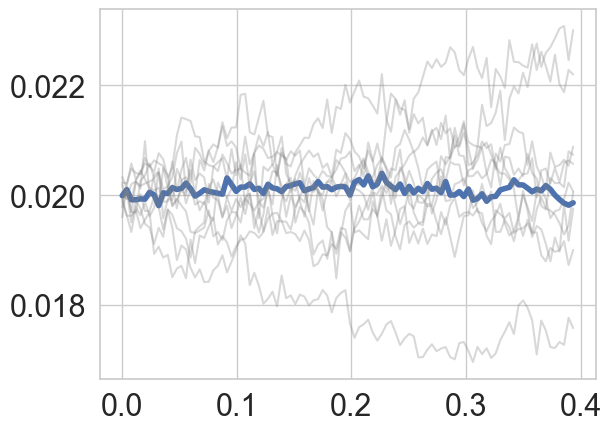

1.0321422815322876
0.6613761782646179
0.35755500197410583
0.08278518915176392
-0.18004561960697174
-0.4426320791244507
-0.7058808207511902
-0.9691134095191956
-1.2313159704208374
-1.4909484386444092
prob of stock increase:  tensor(0.8600)
now running time:  200
Using gp-exp parameterization.
Iter 1/500 - Loss: -2.485
Iter 51/500 - Loss: -2.568
Iter 101/500 - Loss: -2.569
Iter 151/500 - Loss: -2.569
Iter 201/500 - Loss: -2.570
Iter 251/500 - Loss: -2.570
Iter 301/500 - Loss: -2.571
Iter 351/500 - Loss: -2.571
Iter 401/500 - Loss: -2.571
Iter 451/500 - Loss: -2.572
-2.5717861652374268 tensor(-2.5718, grad_fn=<NegBackward>)


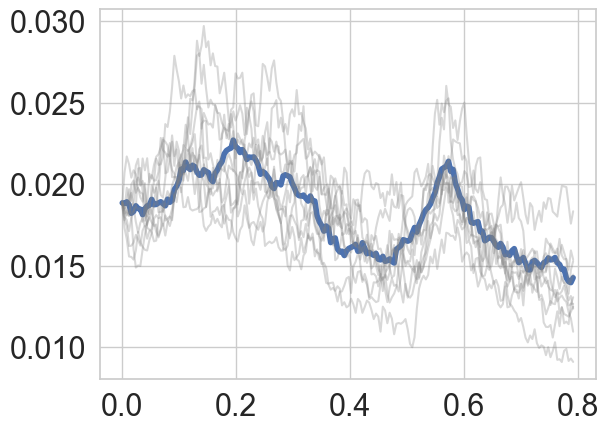

0.9073072671890259
0.6277504563331604
0.37024810910224915
0.11711135506629944
-0.13385078310966492
-0.3837258219718933
-0.6286647915840149
-0.8647107481956482
-1.0896226167678833
-1.301535964012146
prob of stock increase:  tensor(0.7700)
now running time:  300
Using gp-exp parameterization.
Iter 1/500 - Loss: -2.232
Iter 51/500 - Loss: -2.491
Iter 101/500 - Loss: -2.500
Iter 151/500 - Loss: -2.503
Iter 201/500 - Loss: -2.505
Iter 251/500 - Loss: -2.507
Iter 301/500 - Loss: -2.509
Iter 351/500 - Loss: -2.511
Iter 401/500 - Loss: -2.512
Iter 451/500 - Loss: -2.514


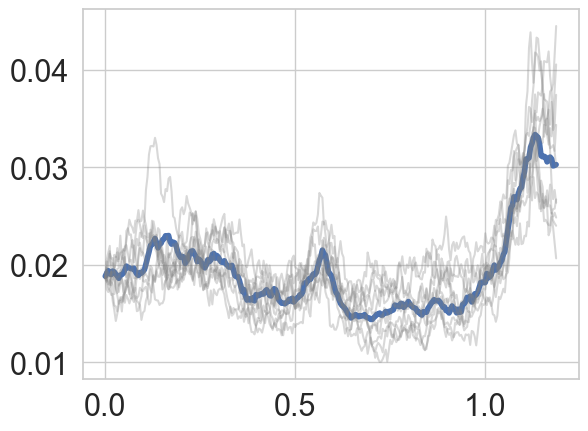

0.861687421798706
0.6149786114692688
0.3759186267852783
0.13455820083618164
-0.10827392339706421
-0.35047608613967896
-0.5877583026885986
-0.8165550827980042
-1.0342133045196533
-1.2384750843048096
prob of stock increase:  tensor(0.5900)
now running time:  400
Using gp-exp parameterization.
Iter 1/500 - Loss: -1.615
Iter 51/500 - Loss: -2.336
Iter 101/500 - Loss: -2.356
Iter 151/500 - Loss: -2.365
Iter 201/500 - Loss: -2.370
Iter 251/500 - Loss: -2.375
Iter 301/500 - Loss: -2.379
Iter 351/500 - Loss: -2.382
Iter 401/500 - Loss: -2.386
Iter 451/500 - Loss: -2.390


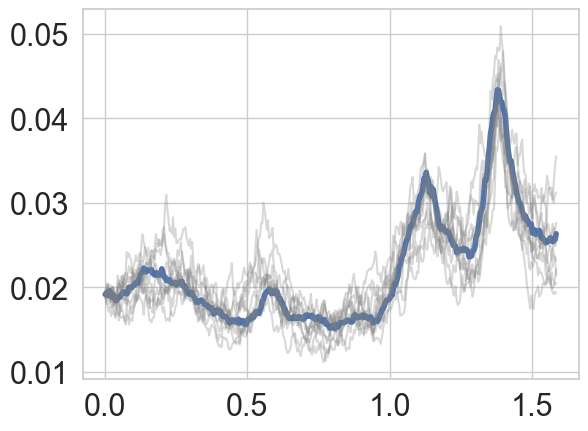

0.8384168744087219
0.6076374650001526
0.377137690782547
0.14070968329906464
-0.09829269349575043
-0.3370267450809479
-0.5722782015800476
-0.8008176684379578
-1.0198431015014648
-1.2270042896270752
prob of stock increase:  tensor(0.6800)
now running time:  500
Using gp-exp parameterization.
Iter 1/500 - Loss: -1.486
Iter 51/500 - Loss: -2.283
Iter 101/500 - Loss: -2.313
Iter 151/500 - Loss: -2.325
Iter 201/500 - Loss: -2.333
Iter 251/500 - Loss: -2.338
Iter 301/500 - Loss: -2.342
Iter 351/500 - Loss: -2.345
Iter 401/500 - Loss: -2.347
Iter 451/500 - Loss: -2.350


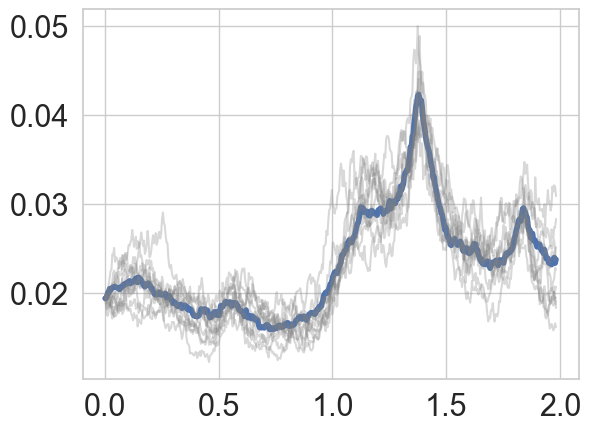

0.8159102201461792
0.5938481688499451
0.3660219609737396
0.1272313892841339
-0.11779046803712845
-0.36453667283058167
-0.6087345480918884
-0.8472958207130432
-1.077734112739563
-1.2978515625
prob of stock increase:  tensor(0.6100)
now running time:  600
Using gp-exp parameterization.
Iter 1/500 - Loss: -1.494
Iter 51/500 - Loss: -2.283
Iter 101/500 - Loss: -2.322
Iter 151/500 - Loss: -2.334
Iter 201/500 - Loss: -2.341
Iter 251/500 - Loss: -2.347
Iter 301/500 - Loss: -2.351
Iter 351/500 - Loss: -2.354
Iter 401/500 - Loss: -2.357
Iter 451/500 - Loss: -2.359


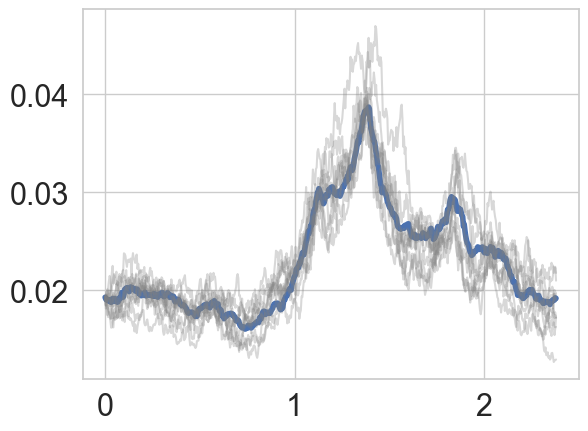

0.8088405132293701
0.5912047028541565
0.3634624183177948
0.12206217646598816
-0.12603719532489777
-0.37630268931388855
-0.6246490478515625
-0.8679825067520142
-1.103917121887207
-1.3304238319396973
prob of stock increase:  tensor(0.6700)
now running time:  700
Using gp-exp parameterization.
Iter 1/500 - Loss: -1.583
Iter 51/500 - Loss: -2.331
Iter 101/500 - Loss: -2.380
Iter 151/500 - Loss: -2.390
Iter 201/500 - Loss: -2.397
Iter 251/500 - Loss: -2.401
Iter 301/500 - Loss: -2.405
Iter 351/500 - Loss: -2.408
Iter 401/500 - Loss: -2.411
Iter 451/500 - Loss: -2.413


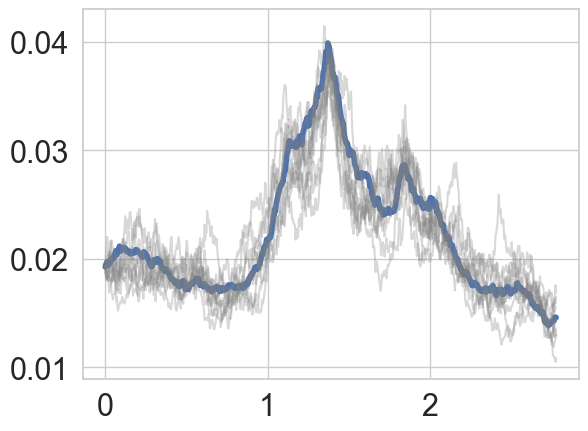

0.7990575432777405
0.5867732167243958
0.36163586378097534
0.12186392396688461
-0.12532618641853333
-0.3757506310939789
-0.6251437067985535
-0.8701330423355103
-1.108191967010498
-1.337159276008606
prob of stock increase:  tensor(0.6200)
now running time:  800
Using gp-exp parameterization.
Iter 1/500 - Loss: -1.356
Iter 51/500 - Loss: -2.088
Iter 101/500 - Loss: -2.314
Iter 151/500 - Loss: -2.343
Iter 201/500 - Loss: -2.353
Iter 251/500 - Loss: -2.361
Iter 301/500 - Loss: -2.367
Iter 351/500 - Loss: -2.372


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/gregorybenton/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-26885d685ca6>", line 6, in <module>
    pred_vol = get_and_fit_gpcv(ts[:time], log_returns[:(time - 1)])
  File "<ipython-input-7-95f04afb7f90>", line 48, in get_and_fit_gpcv
    loss.backward()
  File "/Users/gregorybenton/miniconda3/lib/python3.8/site-packages/torch/_tensor.py", line 255, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/Users/gregorybenton/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py", line 147, in backward
    Variable._execution_engine.run_backward(
  File "/Users/gregorybenton/miniconda3/lib/python3.8/site-packages/torch/autograd/function.py", line 87, in apply
    return self._forward_cls.backward(self, *args)  # type: ignore[attr-defined]
  File "

TypeError: object of type 'NoneType' has no len()

In [12]:
prob_of_increases = []

for i, time in enumerate(eval_times):
    print("now running time: ", time)
    with gpytorch.settings.max_cholesky_size(2000):
        pred_vol = get_and_fit_gpcv(ts[:time], log_returns[:(time - 1)])
        vol_model = get_and_fit_vol_model(ts[:time], pred_vol)
        data_model = get_and_fit_data_model(ts[:time], y[:time], pred_vol, vol_model)
        end_ind = -1 if i + 1 >= len(eval_times) else eval_times[i+1]
        paths = predict_prices(ts[time:end_ind], data_model).detach()
        # now we predict the probability of increase at time i + 1
        prob_of_increase = (paths[..., -1] > y[time]).sum() / paths.shape[-2]
        print("prob of stock increase: ", prob_of_increase.detach())

    prob_of_increases.append(prob_of_increase.detach())

In [13]:
eval_times

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

In [ ]:
i+1 >= len(eval_times)

In [ ]:
plt.plot(eval_times, prob_of_increases)
plt.xlabel("Time")
plt.ylabel("Prob of Stock Increasing")

In [ ]:
from torch.distributions import Beta
from scipy.special import betainc

In [ ]:
xs = torch.linspace(0, 1, 100)

In [ ]:
plt.figure(figsize = (12, 5))
# plt.plot(xs, betainc(3, 3, xs) * 100, label = "Beta(3,3)")
plt.plot(xs, betainc(5, 2, xs) * 100, label = "Beta(5, 2)")
plt.plot(xs, betainc(3, 3, xs) * 100, label = "Beta(3, 3)")
# plt.plot(xs, betainc(1, 1, xs) * 100, label = "Beta(1, 1)")
# plt.plot(xs, betainc(0.5, 0.5, xs) * 100, label = "Beta(0.5, 0.5)")
plt.plot(xs, betainc(10, 10, xs) * 100, label = "Beta(10, 10)")
plt.plot(xs, betainc(20, 20, xs) * 100, label = "Beta(20, 20)")
plt.legend()
plt.xlabel("P(increase)")
plt.ylabel("# Bought")

In [ ]:
prob_incs = torch.tensor(prob_of_increases)

In [ ]:
plt

In [ ]:
bought_func = lambda xs: betainc(5, 2, xs)
total_held = 1000 * bought_func(prob_incs)

In [ ]:
plt.plot(eval_times, total_held, marker = "x")
plt.ylabel("Num Held")
plt.xlabel("Time")

In [ ]:
eval_times

In [ ]:
plt.plot(total_held)

In [ ]:
prices_at_time_y = y[torch.tensor(eval_times)]
delta_y = prices_at_time_y[1:] - prices_at_time_y[:-1]

In [ ]:
plt.plot(eval_times[1:], delta_y)

In [ ]:
total_held.shape

In [ ]:
returns = total_held[1:] * delta_y
cum_returns = returns.cumsum(0)

In [ ]:
plt.plot(eval_times[1:], cum_returns, marker = "x")
plt.ylabel("Cum Returns")
plt.xlabel("Time")

In [ ]:
def reward_risk(a, b):
    bought_func = lambda xs: betainc(a, b, xs)
    total_held = 1000 * bought_func(prob_incs)
    
    returns = total_held[1:] * delta_y
    #cum_returns = returns.cumsum(0)
    return returns.std(), returns.sum()

In [ ]:
a_s = torch.rand(20) * 20
mpts = [reward_risk(x, 1) for x in a_s]

In [ ]:
a_s

In [ ]:
f = plt.scatter(*torch.tensor(mpts).t(), c=a_s)
plt.colorbar(f, label = "a")
plt.ylabel("Return")
plt.xlabel("Standard Deviation")

In [ ]:
vals = torch.rand(1500, 2) * 20
mtps = torch.tensor([reward_risk(x[0], x[1]) for x in vals])

In [ ]:
mtps.shape

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (11, 5))
f = ax[0].scatter(vals[:,0], vals[:,1], c=mtps[:,1])
ax[0].set_title("Return")
fig.colorbar(f, ax=ax[0])

f = ax[1].scatter(vals[:,0], vals[:,1], c=mtps[:,0])
ax[1].set_title("SD Return")
fig.colorbar(f, ax = ax[1])
plt.tight_layout()

[ax[i].set_xlabel("a") for i in range(2)]
[ax[i].set_ylabel("b") for i in range(2)]

In [ ]:
from botorch.utils.multi_objective import is_non_dominated

In [ ]:
scaling = torch.ones(2)
scaling[0] = -1.
pf_bool = is_non_dominated(mtps * scaling)
plt.scatter(*mtps.t(), alpha = 0.2, c = ["orange"] * 1500)
plt.scatter(*mtps[pf_bool].t(), label = "Pareto Front", color = "blue")
plt.ylabel("Return")
plt.xlabel("SD Return")
plt.legend()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (11, 5))
f = ax[0].scatter(vals[:,0], vals[:,1], c=mtps[:,1])
ax[0].scatter(vals[pf_bool,0], vals[pf_bool,1], color = "blue")
ax[0].set_title("Return")
fig.colorbar(f, ax=ax[0])

f = ax[1].scatter(vals[:,0], vals[:,1], c=mtps[:,0])
ax[1].scatter(vals[pf_bool,0], vals[pf_bool,1], color = "blue", label = "Pareto Pts")
ax[1].set_title("SD Return")
ax[1].legend(loc = "lower right")
fig.colorbar(f, ax = ax[1])
plt.tight_layout()

[ax[i].set_xlabel("a") for i in range(2)]
[ax[i].set_ylabel("b") for i in range(2)]

In [ ]:
plt.subplots(figsize = (8, 5))
[plt.plot(xs, 1000. * betainc(*v, xs), color = "maroon", alpha = 0.3) for v in vals[pf_bool]]
sns.despine()
plt.xlabel("P(increase)")
plt.ylabel("# of Stocks Held")

In [ ]:
# torch.save(obj=prob_of_increases, f="voltron_v.pt")